**09.02.2025 Checkpoint №1**

**Stress Detection**

*Ссылка на датасет* https://www.kaggle.com/code/dheerov/stress-detection/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Сохранил в папку stress/ гружу и вывожу .head
stressed_df = pd.read_csv('stress/data_stress.csv')
stressed_df.head(5)

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate,Stress Levels
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


**Описание данных:**

**snoring range** - *громкость храпа в дБ, дробная с точностью до сотых, количественная, непрерывная;*\
**respiration rate** - *количество дыхательных циклов в минуту, дробные с точностью до сотых, количественная, непрерывная;*\
**body tempreture** - *температура тела в градусах по F, дробная с точностью до тысячных, количественная, непрерывная;*\
**limb movement** - *движения конечностей в час, дробная с точностью до сотых, количественная, непрерывная;*\
**blood oxygen** - *процентное содержание насыщенного кислородом гемоглобина в крови в крови (сатурация), дробная с точностью до сотых, количественная, непрерывная;*\
**eye movement** - *количество движений глаз в час, дробная с точностью до сотых, количественная, непрерывная;*\
**hours of sleep** - *часы сна, дробная с точностью до тысячных, количественная, непрерывная;*\
**heart rate** - *средняя частота сердечных сокращений в минуту, дробная с точностью до сотых, количественная, непрерывная;*\
**Stress levels** - *уровень стресса 0-4, целое, категориальная.*

*Двигаемся дальше*

**15.03.2025 Checkpoint №2**

**1 Описание признаков**

In [3]:
stressed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   snoring range     630 non-null    float64
 1   respiration rate  630 non-null    float64
 2   body temperature  614 non-null    float64
 3   limb movement     618 non-null    float64
 4   blood oxygen      626 non-null    float64
 5   eye movement      612 non-null    float64
 6   hours of sleep    619 non-null    float64
 7   heart rate        606 non-null    float64
 8   Stress Levels     630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [4]:
signs = {'number': 'Количественные', 'category': 'Категориальные', 'bool': 'Номинальные'}
for k, v in signs.items():
    print(f"{v} признаки:")
    s_temp = stressed_df.select_dtypes(include=[k]).columns.to_list()
    if len(s_temp) > 0:
        for s in stressed_df.select_dtypes(include=[k]).columns.to_list():
            print(f"- {s};")
    else:
        print('- отсутствуют;')


Количественные признаки:
- snoring range;
- respiration rate;
- body temperature;
- limb movement;
- blood oxygen;
- eye movement;
- hours of sleep;
- heart rate;
- Stress Levels;
Категориальные признаки:
- отсутствуют;
Номинальные признаки:
- отсутствуют;


*Stress Levels по факту является категориальным признаком, приведу его к категориальному типу, чтобы оптимизировать память.*

In [5]:
stressed_df['Stress Levels'] = stressed_df['Stress Levels'].astype('category')
stressed_df['Stress Levels'].info()
print('\nТип успешно был изменен на "категориальный".')

<class 'pandas.core.series.Series'>
RangeIndex: 630 entries, 0 to 629
Series name: Stress Levels
Non-Null Count  Dtype   
--------------  -----   
630 non-null    category
dtypes: category(1)
memory usage: 974.0 bytes

Тип успешно был изменен на "категориальный".


**2 Работа с пропусками и выбросами**

In [6]:
missing_values = pd.DataFrame(stressed_df.isnull().sum()).reset_index().rename(columns={'index': 'field', 0: 'count'})
missing_values['percentage'] = (missing_values['count'] / stressed_df.shape[0]) * 100
missing_values

,field,count,percentage
0,snoring range,0,0.000000
1,respiration rate,0,0.000000
2,body temperature,16,2.539683
3,limb movement,12,1.904762
4,blood oxygen,4,0.634921
5,eye movement,18,2.857143
6,hours of sleep,11,1.746032
7,heart rate,24,3.809524
8,Stress Levels,0,0.000000


*Причина появления пропусков? - В нашем случае измерения проводятся пока человек спит, вполне возможно, что человек мог сделать резкое движение во сне, например неудачно повернуться на другой бок и какой-то из датчиков отошел. Впрочем я не исключаю и банальную ошибку при считывании тех или иных показателей.*

*Прежде чем перейти к заполнению пропусков, стоит проверить выбросы в наших данных. Тк мы наблюдаем пропуски исключительно в количественных непрерывных признаках, стандартным подходом будет - замена средним .mean(), однако, если фактор выбросов критичен, то стоит остановиться на медианных значениях. Так или иначе, замена пропусков, вместо удаления строк, позволит сохранить целостность данных и их количество, что особенно важно для нашего случая, тк у нас ограниченное количество наблюдений.*

In [7]:
# Для начала поищем выбросы с помощью IQR для количественных признаков
def iqr(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    return (group < lower) | (group > upper)

# На будущее сохраню отдельно количественные и категориальные переменные
numeric = stressed_df.select_dtypes(include=['number']).columns
categorical = stressed_df.select_dtypes(include=['category']).columns

outliers_df = []
for stress_level in stressed_df['Stress Levels'].unique():
    data_tmp = stressed_df[stressed_df['Stress Levels'] == stress_level]
    for col in numeric:
        outlier_cnt = iqr(data_tmp[col]).sum()
        outliers_df.append({'stress_level': stress_level, 'feature': col, 'count': outlier_cnt})
outliers_df = pd.DataFrame(outliers_df)
print(outliers_df.sort_values(by=['stress_level'], ascending=True))

    stress_level           feature  count
19             0     limb movement      2
21             0      eye movement      0
20             0      blood oxygen      0
18             0  body temperature      0
17             0  respiration rate      0
16             0     snoring range      0
22             0    hours of sleep      2
23             0        heart rate      0
8              1     snoring range      0
9              1  respiration rate      0
10             1  body temperature      1
12             1      blood oxygen      0
13             1      eye movement      4
14             1    hours of sleep      0
15             1        heart rate      1
11             1     limb movement      1
26             2  body temperature      1
27             2     limb movement      1
28             2      blood oxygen      1
29             2      eye movement      0
24             2     snoring range      0
30             2    hours of sleep      4
31             2        heart rate

In [8]:
outliers_df.groupby(['feature'])['count'].sum()

feature
blood oxygen        2
body temperature    8
eye movement        4
heart rate          4
hours of sleep      7
limb movement       7
respiration rate    3
snoring range       0
Name: count, dtype: int64

*Выбросы достаточно немногочисленны, но это не означает, что их можно игнорировать! Давайте посмотрим как это выглядит на boxplot'ах)*

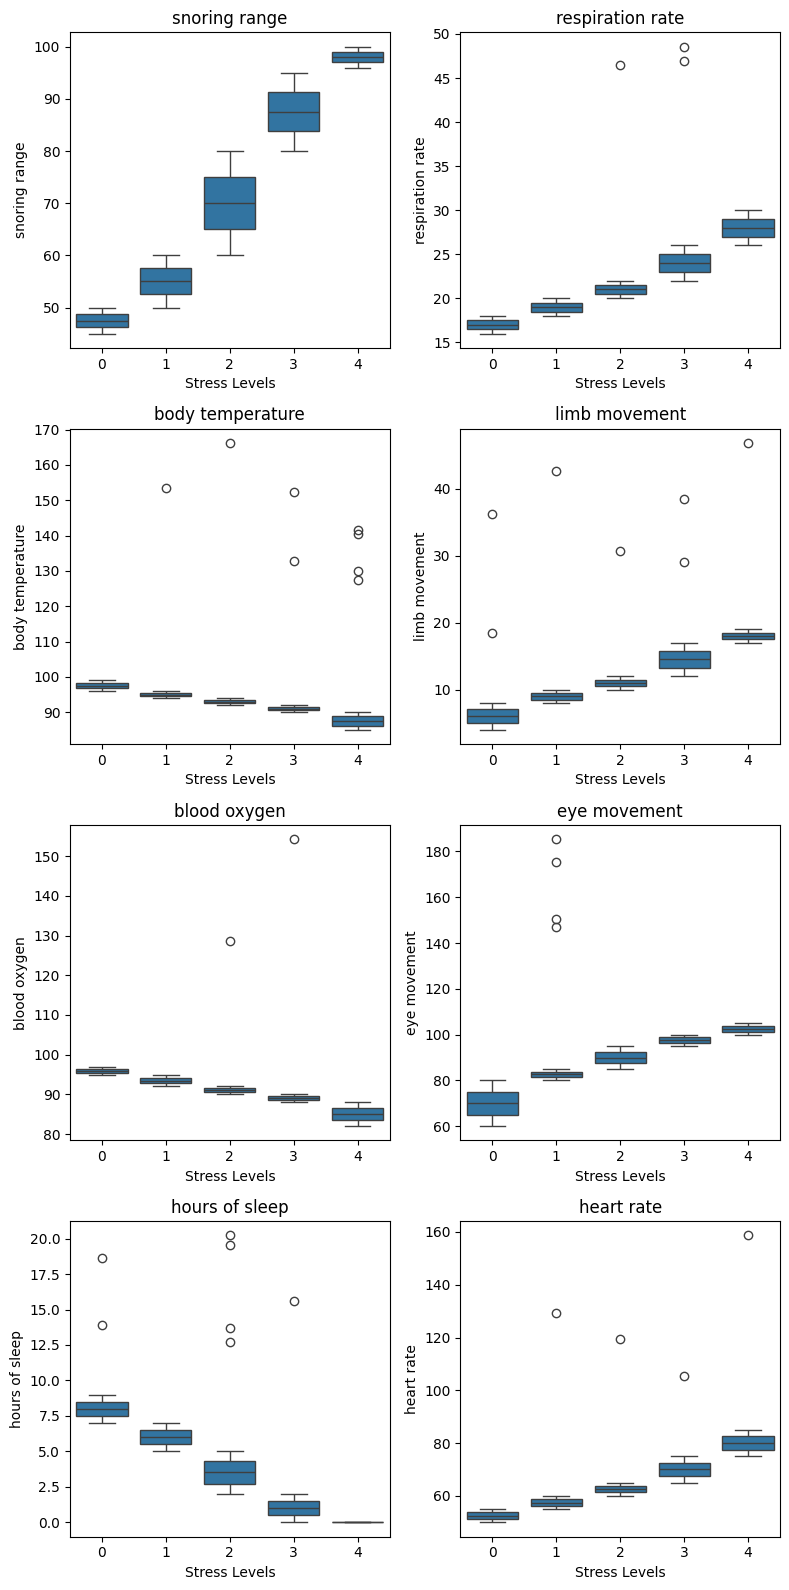

In [9]:
features = stressed_df.columns[0:-1]
plt.figure(figsize=(8,16))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='Stress Levels', y=feature, data=stressed_df)
    plt.title(feature)
plt.tight_layout()
plt.show()

*Для оценки выбросов я построил боксплоты для каждого признака в зависимости от уровня стресса. Здесь мы видим, что выбросы есть для всех признаков, кроме 'snoring range' (громкость храпа). По признакам для которых присутствуют выбросы - примем решение по порядку:*  
**respiration rate** - *мы видим 3 наблюдения, в которых пациенты дышали аномально быстро в сравнении с остальными испытуемыми. Однако нельзя исключать эти случаи, столь частое дыхание может быть вызвано респираторными или хроническими заболеваниями дыхательных путей. Вердикт - окончательное решение принять на этапе выбора модели.*  
**body temperature** - *Нормальная температура человеческого тела — 36.6 °C ±0.7 °C, или 98.2 °F ±1.3 °F, температура 42 °C или же 107,6 °F является опасным для жизни состоянием или гиперпиретической лихорадкой. Крайне маловероятно, что в исследовании принимали участие люди с заболеваниями в острой форме, характеризующимися сильно повышенной температурой тела, поэтому будет разумным считать выбросами значения, выходящие за границы нормальных параметров, а именно 98.2 °F ±1.3 °F. Вердикт - значения, выходящие за обозначенные границы заменить медианой.*  
**limb movement** - *здесь сложно провести однозначную оценку корректности выбросов, при высоком уровне стресса возможны более активные движения во сне. Вердикт - окончательное решение принять на этапе выбора модели.*  
**blood oxygen** - *достоверно известно, что сатурация (процентное содержание насыщенного кислородом гемоглобина в крови в крови) не может превышать 100%. Вердикт - значения, выходящие за обозначенные границы заменить медианой.*  
**eye movement** - *аномально высокое количество движений глаз наблюдается только для уровня стресса 1, поэтому я могу предположить, что это связано с неизвестной нам повторяющейся ошибкой в вычислениях. Так или иначе, наличие таких значений только для одной категории можешь существенно сказаться на точности нашей модели. Вердикт - значения, выходящие за обозначенные границы заменить медианой.*  
**hours of sleep** - *продолжительность сна более 12 часов в сутки рекомендована только для детей в возрасте до 5 лет, к сожалению у нас отсутствуют данные о возрасте испытуемых, но потенциально столь длительный сон возможен. Вердикт - окончательное решение принять на этапе выбора модели.*  
**heart rate** - *мы наблюдаем 4 измерения, которые явно являются аномальными. Нормальным считается пульс в диапазоне 40-50 уд/мин для спящего человека. При нарушении качества сна или заболеваниях сердечно-сосудистой системы пульс может превышать 90 уд/мин во время сна. В общих чертах описанная выше тенденция наблюдается, однако имеющиеся 4 наблюдения с крайне высоким пульсом, которые могут существенно повлиять на точность определения уровня стресса. Вердикт - окончательное решение принять на этапе выбора модели.*

In [10]:
# Теперь, когда мы разобрались с выбросами, сначала обработаем их, а затем перейдем к обработке пропусков
def replace_outliers_median(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    median_v = group.median() # берем медиану для последующей замены
    return np.where((group < lower) | (group > upper), median_v, group)

for col in numeric:
    stressed_df[col] = stressed_df.groupby('Stress Levels', observed=False)[col].transform(replace_outliers_median)

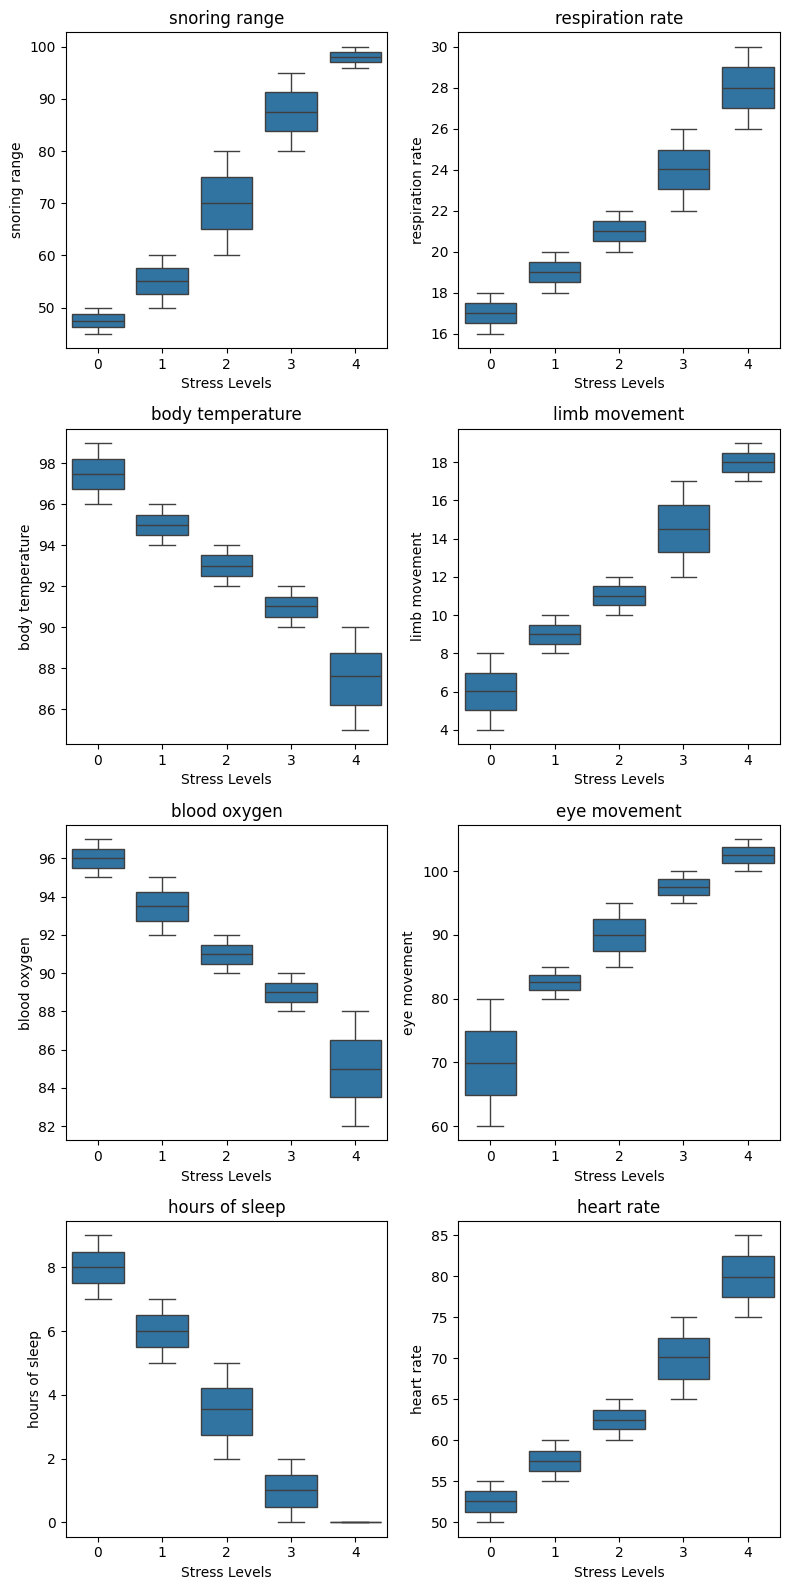

In [11]:
# Проверяем, что у нас получилось
features = stressed_df.columns[0:-1]
plt.figure(figsize=(8,16))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='Stress Levels', y=feature, data=stressed_df)
    plt.title(feature)
plt.tight_layout()
plt.show()

*Теперь, когда мы решили проблему выбросов, мы со спокойной душой можем использовать среднее значение для заполнения пропусков.*

In [12]:
# Выведем описательные статистики перед заменой и после
stressed_df.describe()

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate
count,630.000000,630.000000,614.000000,618.000000,626.000000,612.000000,619.000000,606.00000
mean,71.600000,21.800648,92.782085,11.681294,90.883463,88.428824,3.701829,64.50066
std,19.372833,3.965369,3.513403,4.295466,3.904615,11.940945,3.059245,9.90401
min,45.000000,16.000000,85.000000,4.000000,82.000000,60.000000,0.000000,50.00000
25%,52.500000,18.500000,90.516000,8.484000,88.484000,81.230000,0.472000,56.21000
50%,70.000000,21.012000,92.976000,11.000000,90.984000,89.760000,3.572000,62.50000
75%,91.250000,24.968000,95.468000,15.710000,94.226000,98.730000,6.512000,72.50000
max,100.000000,30.000000,99.000000,19.000000,97.000000,105.000000,9.000000,85.00000


In [13]:
for col in numeric:
    stressed_df[col] = stressed_df.groupby('Stress Levels', observed=False)[col].transform(lambda x: x.fillna(x.mean()))

**3 Описаельные статистики по переменным**

In [14]:
stressed_df.describe()

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.800648,92.801132,11.704074,90.892877,88.485248,3.699062,64.508110
std,19.372833,3.965369,3.522074,4.289828,3.899618,11.908455,3.052757,9.892435
min,45.000000,16.000000,85.000000,4.000000,82.000000,60.000000,0.000000,50.000000
25%,52.500000,18.500000,90.532000,8.516000,88.500000,81.290000,0.500000,56.250000
50%,70.000000,21.012000,92.994387,11.006439,90.989120,89.996000,3.524000,62.514622
75%,91.250000,24.968000,95.500000,15.710000,94.226000,98.670000,6.500000,72.420000
max,100.000000,30.000000,99.000000,19.000000,97.000000,105.000000,9.000000,85.000000


*Видим, что после замены незначительно изменились такие метрики как среднее и например 25% квантиль для 'body temperature'.*

*Если присмотреться к средним и медианным значениям - мы увидим, что они отличаются незначительно, поэтому я выдвигаю гипотезу, что наше распределение близко к нормальному. На 3-м этапе займусь проверкой данной гипотезы.*

**4 Изучаем признаки и принимаемые ими значения**

In [15]:
our_signs = {'number': 'Количественные', 'category': 'Категориальные'}
for s, n in our_signs.items():
    print(f"Рассмотрим {n} признаки:")
    if s == 'number':
        for v in numeric:
            print(f"{v} принимает значения в диапазоне: {stressed_df[v].min()} - {stressed_df[v].max()};")
    elif s == 'category':
        for v in categorical:
            print(f"{v} может принимать уникальные значения: {stressed_df[v].unique()};")

Рассмотрим Количественные признаки:
snoring range принимает значения в диапазоне: 45.0 - 100.0;
respiration rate принимает значения в диапазоне: 16.0 - 30.0;
body temperature принимает значения в диапазоне: 85.0 - 99.0;
limb movement принимает значения в диапазоне: 4.0 - 19.0;
blood oxygen принимает значения в диапазоне: 82.0 - 97.0;
eye movement принимает значения в диапазоне: 60.0 - 105.0;
hours of sleep принимает значения в диапазоне: 0.0 - 9.0;
heart rate принимает значения в диапазоне: 50.0 - 85.0;
Рассмотрим Категориальные признаки:
Stress Levels может принимать уникальные значения: [3, 1, 0, 2, 4]
Categories (5, int64): [0, 1, 2, 3, 4];


**5 Корреляционная матрица**

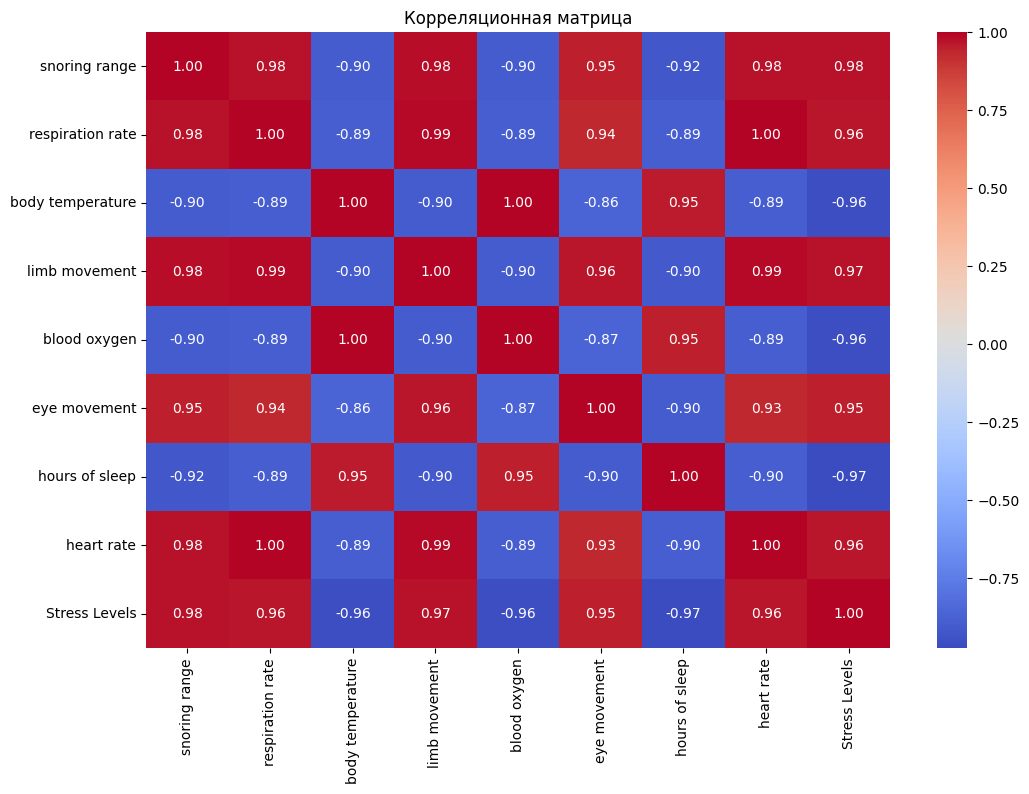

In [16]:
plt.figure(figsize=(12,8))
corr_matrix = stressed_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Корреляционная матрица')
plt.show()

**Важный вывод:**
*Вот прям сразу можем проследить корреляцию например между движением конечностей и пульсом, уровнем стресса и храпом, длительностью сна и сатурацией (вообще это параметр, который действительно очень влияет на качество сна, именно поэтому мы так хорошо спим в загородном доме вблизи леса). Чисто с медицинской точки зрения, матрица выглядит очень реалистично.

**6 Визуализация данных**

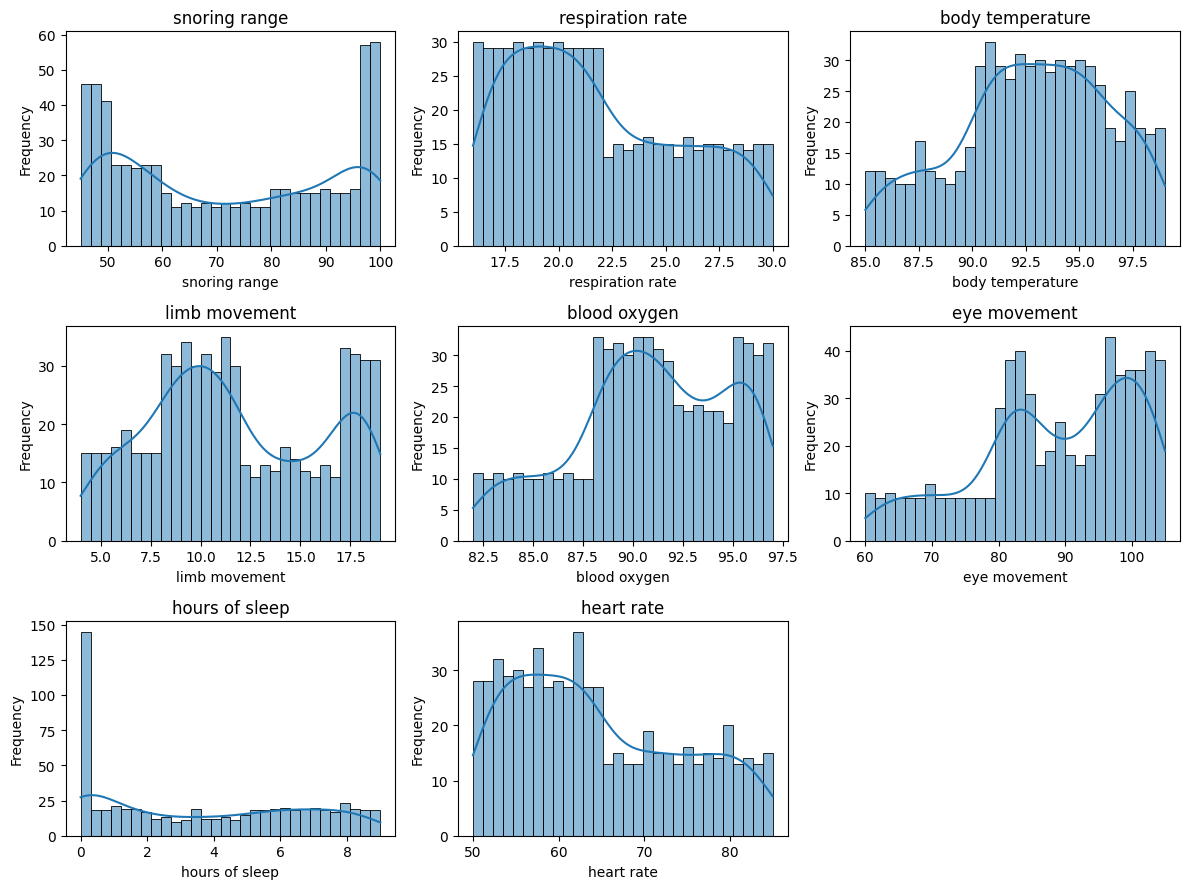

In [17]:
# Гистограммы распределения числовых показателей
plt.figure(figsize=(12, 9))
for i, col in enumerate(numeric, 1):
    plt.subplot(3, 3, i)
    sns.histplot(stressed_df[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

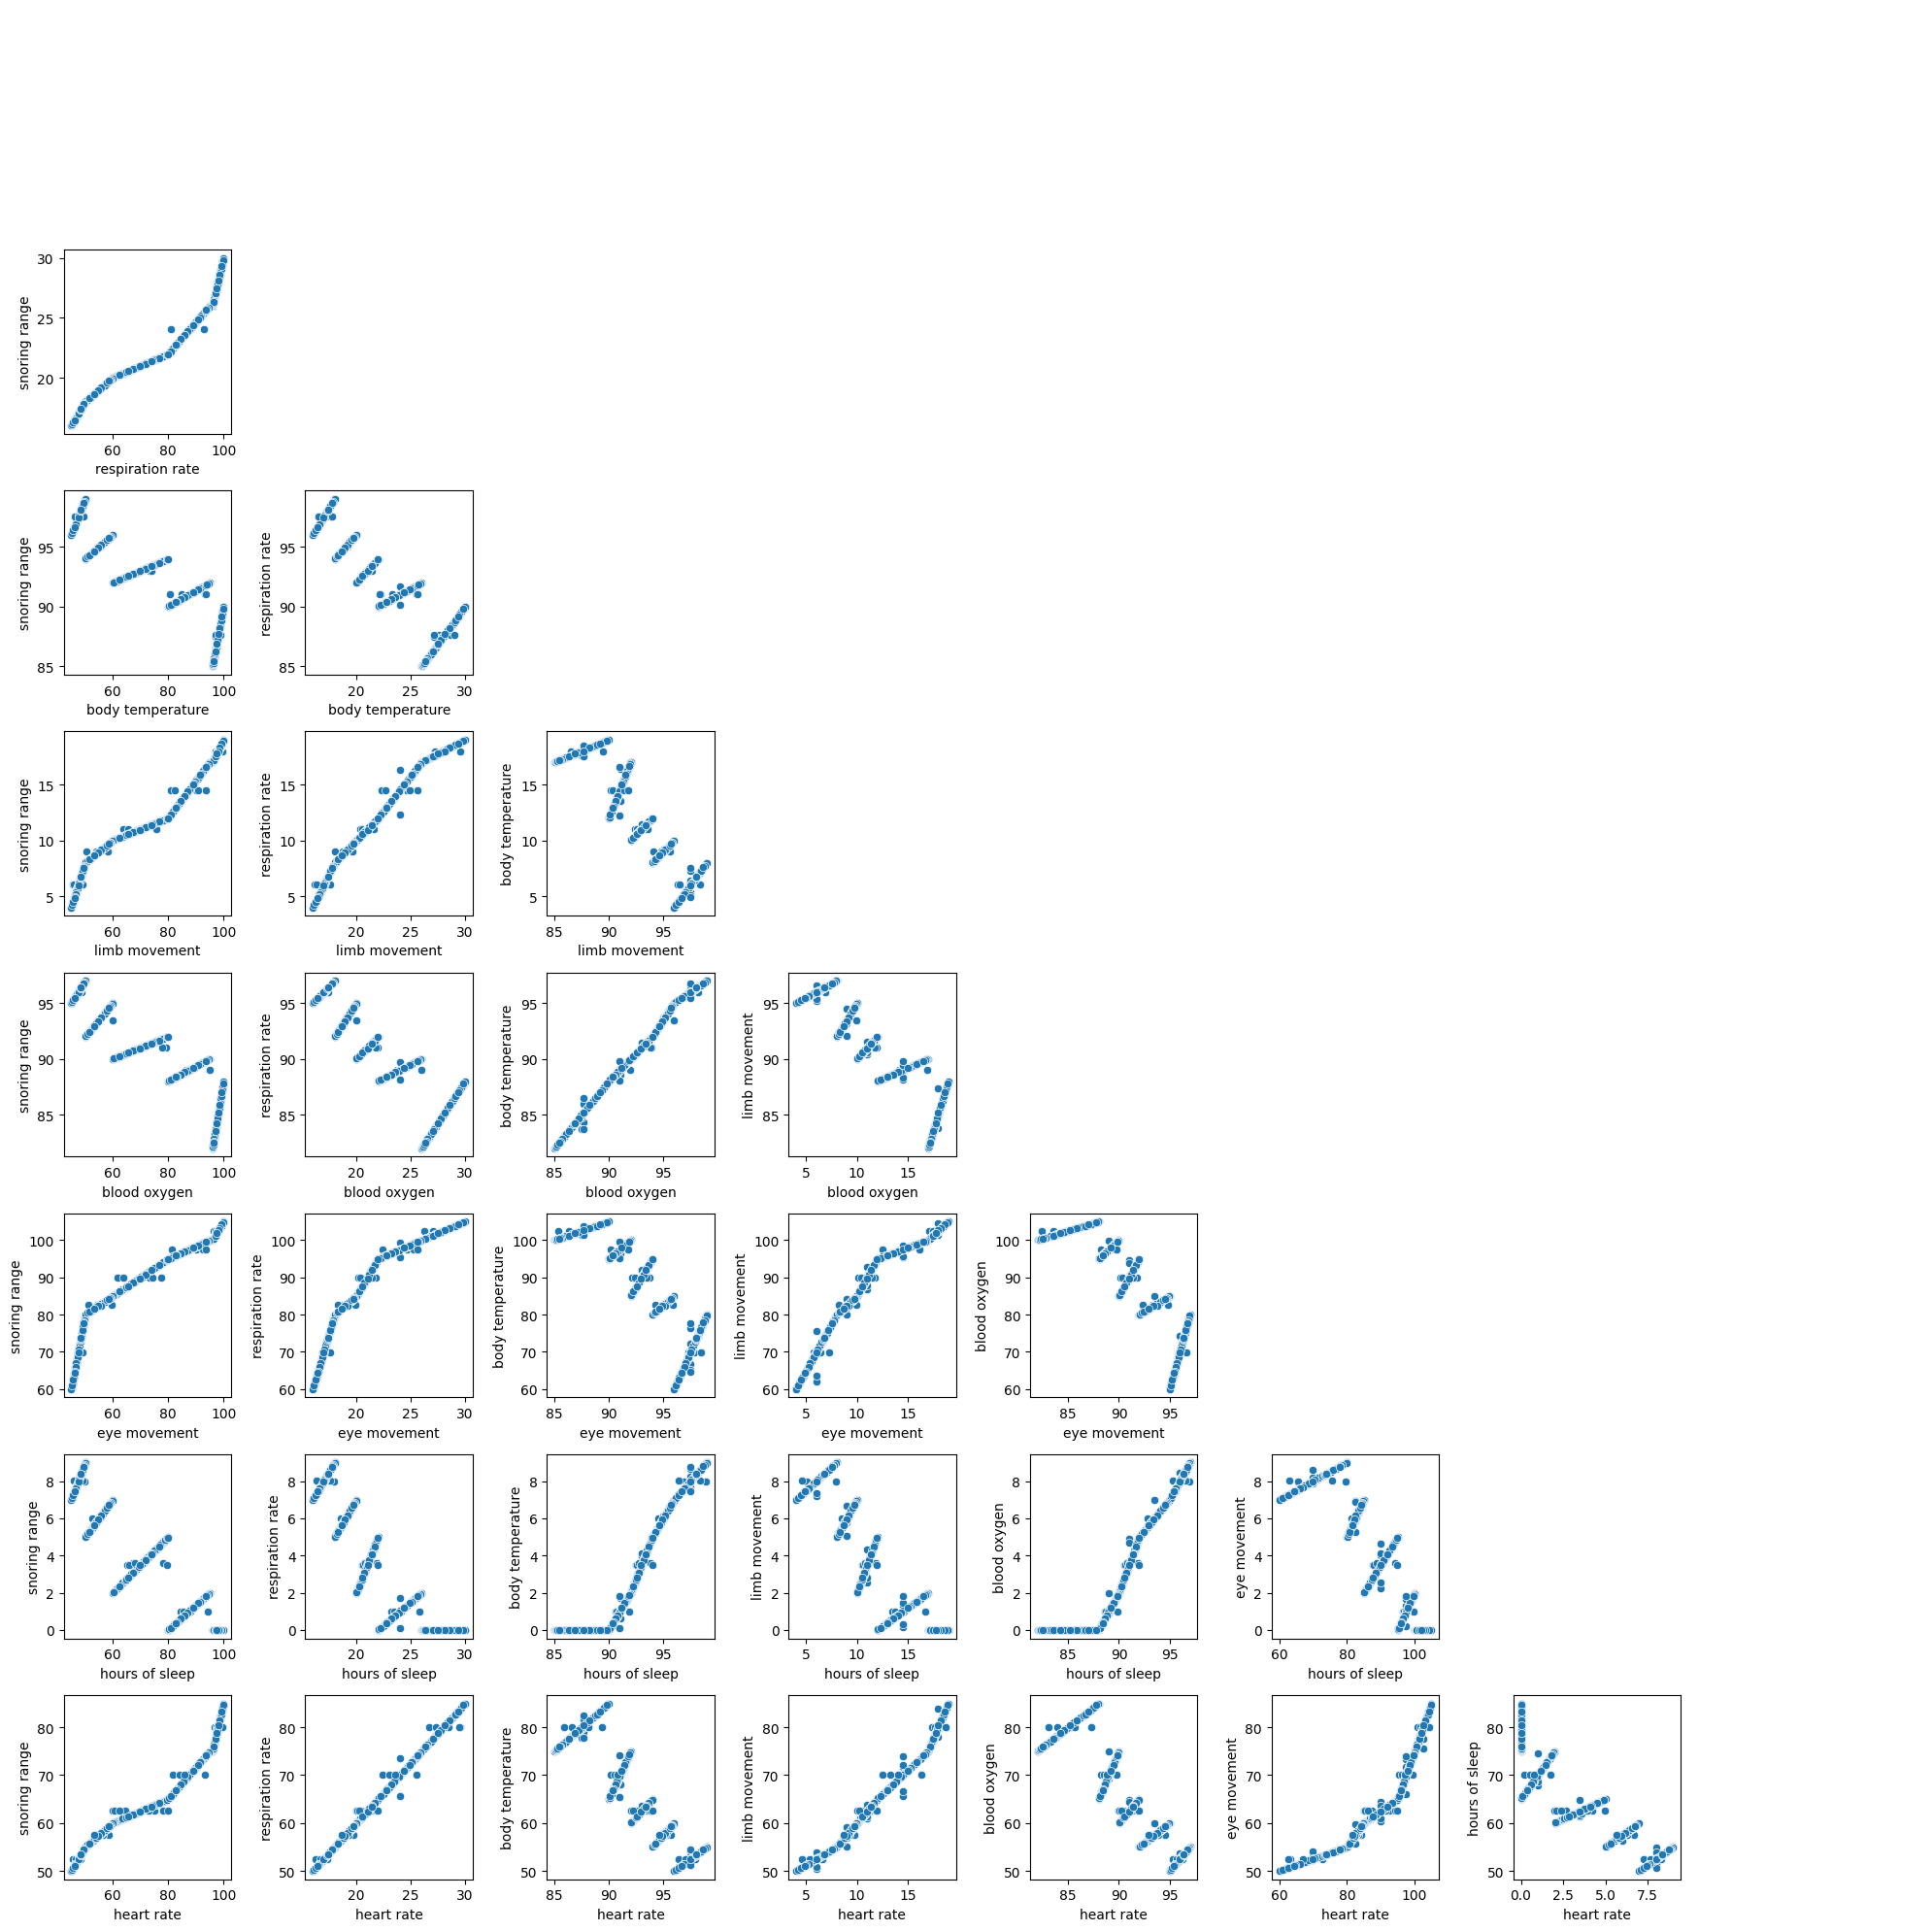

In [18]:
# Вариант без извращений для попарных связей
#plt.figure(figsize=(12, 8))
#sns.pairplot(stressed_df[numeric], corner=True) # corner отрезает все, что выше диагонали
#plt.show()

# Вариант с извращением
plt.figure(figsize=(20, 20))
num_cols = len(numeric)
for i in range(num_cols):
    for j in range(num_cols):
        if i > j:
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            sns.scatterplot(data=stressed_df, x=numeric[j], y=numeric[i])
            plt.xlabel(numeric[i])
            plt.ylabel(numeric[j])
        else:
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1).axis('off')

plt.tight_layout()
plt.show()

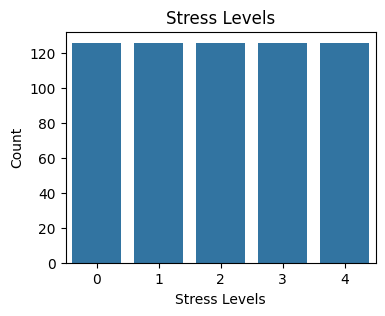

In [19]:
# Пусть у нас всего 1 категориальная переменная, но и для неё постоим, хехе
plt.figure(figsize=(4, 3))
sns.countplot(data=stressed_df, x=categorical[0])
plt.title(f'{categorical[0]}')
plt.xlabel(categorical[0])
plt.ylabel('Count')
plt.show()

*PS у нас по 126 измерений для каждого уровня стресса.*

**Выводы**  
*Исходя из увиденного можно заключить:*  
*- наблюдается четкая связь между повышением уровня стресса и снижением продолжительности сна;
- с повышением уровня стресса усиливается храп, повышается частота сердечных сокращений и дыхания;
- процент пропусков для всех полей датафрейма не превышает 4%, пропуски были заполнены средними для каждой группы по уровню стресса;
- выбросы были обработаны с помощью метода IQR, а также разобраны логически, с упором в медицинскую практику;*

**Гипотезы для дальнейшего исследования**  
*1 Распределением большинства признаков близко к нормальному;*  
*2 Низкое качество сна может быть как следствием, так и причиной увеличения уровня стресса;*  
*3 Вероятно существование различных типов реакций на стресс (например, разные изменения пульса, храпа или температуры), что можно проверить с помощью кластерного анализа;*  